In [3]:
# Import libraries here
library(dplyr)
library(class)
library(MASS)
library(Hmisc)
library(klaR)
library(e1071)
library(kknn)
library(rpart)
library(lars)
library(stats)
library(leaps)
library(repr)
library(glmnet)
library(caret)
library(ggplot2)


# Get the data
df_Base = '/Users/sam/All-Program/App-DataSet/Data-Science-Projects/Diabetic-Readmission/diabetes_dataset/df_Base.csv'
df_F1 = '/Users/sam/All-Program/App-DataSet/Data-Science-Projects/Diabetic-Readmission/diabetes_dataset/df_F1.csv'
df_F2 = '/Users/sam/All-Program/App-DataSet/Data-Science-Projects/Diabetic-Readmission/diabetes_dataset/df_F2.csv'

df_Diag1Diag2NaN_rmv_F1 = '/Users/sam/All-Program/App-DataSet/Data-Science-Projects/Diabetic-Readmission/diabetes_dataset/df_Diag1Diag2NaN_rmv_F1.csv'
df_Diag1Diag2NaN_rmv_F2 = '/Users/sam/All-Program/App-DataSet/Data-Science-Projects/Diabetic-Readmission/diabetes_dataset/df_Diag1Diag2NaN_rmv_F2.csv'

# Choose the feature you want to run
runningDataSet <- df_F1

seed <- 45223

### See if the data looks good, and the features are provided with correct attributes:

In [4]:
# Check the data if its looks alright
file_names <- list.files(path = runningDataSet, pattern = ".csv", full.names = TRUE)
data.total <- do.call(rbind,lapply(file_names, read.csv, header=TRUE))
data.total = data.frame(data.total)
# Check how many unique output labels we have, should be binomial (no, and yes)
unique(data.total$readmitted)
head(data.total)

[1] no  yes
Levels: no yes

time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,⋯,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide_metformin,glipizide_metformin,change,diabetesMed,readmitted
1,41,0,1,0,0,0,1,Caucasian,Female,⋯,No,No,No,No,No,No,No,No,No,no
3,59,0,18,0,0,0,9,Caucasian,Female,⋯,No,No,No,No,Up,No,No,Ch,Yes,no
2,11,5,13,2,0,1,6,AfricanAmerican,Female,⋯,No,No,No,No,No,No,No,No,Yes,no
2,44,1,16,0,0,0,7,Caucasian,Male,⋯,No,No,No,No,Up,No,No,Ch,Yes,no
1,51,0,8,0,0,0,5,Caucasian,Male,⋯,No,No,No,No,Steady,No,No,Ch,Yes,no
3,31,6,16,0,0,0,9,Caucasian,Male,⋯,No,No,No,No,Steady,No,No,No,Yes,no


# Common Functions:
-------

In [5]:
bindModel <- function(yLabel, xFeatures=NULL, featureSet=NULL){
    # Automates the creation of feature model to be passed into an Classifier or Predictive Model
    if (is.null(xFeatures)){
        xFeatures <- featureSet[featureSet != yLabel]
    }   
    return (as.formula(paste(yLabel, "~", paste(xFeatures, collapse = '+ '))))
}



dummy_DF_Builder <- function (dataIN, factorModel, factorCols, numericCols, labelCol, intercept=FALSE){
# Inp:
    # Takes input a complete dataframe 
    # Takes input a factorModel ex = label~ attr1 + attr2 + att3 + att2*att4 where att1, attr2, attr3 are all factor columns
    # Takes input the factor features, numeric features and the label 
#Out:
    # Creates a design matrix by expanding the factors to a set of dummy variables and interaction etc.
    # Returns a dataframe with the numerical features, the expanded dummy features and the label
    
    stopifnot(length(intersect(numericCols,factorCols)) == 0 )
    stopifnot(labelCol %in% factorCols == FALSE)
    stopifnot(labelCol %in% numericCols == FALSE)
    
    xFactor <- dataIN[, c(factorCols, labelCol)]
    
    if (intercept){
        xFactor <- model.matrix(factorModel, data=xFactor)
    }
    else{
        xFactor <- model.matrix(factorModel, data=xFactor)[-1]     # To remove the intercept term that lies in the first column
    }

    xNumeric <- dataIN[, numericCols]
    yLabel <- dataIN[labelCol]

    return (data.frame(xFactor, xNumeric, yLabel))
}


stratifiedSampling <- function(dataIN, sample_on_col, trainPrcnt, seed){
  set.seed(seed)
  trainIndices <- createDataPartition(y=dataIN[[sample_on_col]], p=trainPrcnt, list=FALSE)
  trainData <- dataIN[trainIndices,]
  testData <- dataIN[-trainIndices,]
  
  stopifnot(nrow(trainData) + nrow(testData) == nrow(dataIN))
  return (list(trainData, testData))
}


changeDataType <- function(dataIN, featureNames, type){
    if (type=='factor'){
        dataIN[featureNames] <- lapply(dataIN[featureNames], factor)
    }
    else if (type=='numeric'){
        dataIN[featureNames] <- lapply(dataIN[featureNames], as.numeric)
    }
    else{
        print ('No Type Specified! Specify a Type Factor or Numeric')
    }
    return (dataIN)
}



performanceMetric <- function (cutoffRange, y, y_hat){
    y_bin <- y_hat
    actualYesIndex <- which(y==1)
#     perfMetric <- data.frame()
    perfMetric <- matrix(0,length(cutoffRange),3)    # 3 is because we calculate accuracy, recall and precision
    for (i in 1:length(cutoffRange)){
#         print (cutOFF)
        predYesIndex <- which(y_hat>=cutoffRange[i])
        bothYesIndex <- intersect(actualYesIndex,predYesIndex)

        # Get the Binomial prediction based on cut-off value
        y_bin[predYesIndex] <- 1
        y_bin[-predYesIndex] <- 0

        # Calculate the accuracy, precision and recall
        accuracy <- length(which(y_bin == y))/length(y)
        precision <- length(bothYesIndex)/length(predYesIndex)
        recall <- length(bothYesIndex)/length(actualYesIndex)
        cbind(accuracy, precision, recall)
        
        perfMetric[i,] <- cbind(accuracy, precision, recall)
    }
    
    return (perfMetric)
 
}


plotPerfMetric <- function(performanceDF, cutoffRange){
    p <- ggplot() + 
      geom_line(data = performanceDF, aes(x = cutoffRange, y = accuracy, color = "accuracy")) +
      geom_line(data = performanceDF, aes(x = cutoffRange, y = precision, color = "precision")) +
      geom_line(data = performanceDF, aes(x = cutoffRange, y = recall, color = "recall")) +
      xlab('Cutoff') +
      ylab('percent.change')
    return (p)
}

In [6]:
gender = c('male','female','male','male', 'female')
age = c('10-20','10-20','20-30','10-20', '30-40')
place = c('chicago', 'newyork', 'chicago', 'calif', 'newyork')
weight = c(70,40,90,40,60)
disease = c(1,1,0,1,0)

dataIN <- data.frame(gender,age,place,weight,disease)
factorModel = disease~gender+age+place+gender*age
numericCols = c('weight')
nominalCols = c('gender', 'age','place')
labelCol = c('disease')

a <- dummy_DF_Builder(dataIN, factorModel, nominalCols, numericCols, labelCol, intercept=TRUE)

a
# dataIN

X.Intercept.,gendermale,age20.30,age30.40,placechicago,placenewyork,gendermale.age20.30,gendermale.age30.40,xNumeric,disease
1,1,0,0,1,0,0,0,70,1
1,0,0,0,0,1,0,0,40,1
1,1,1,0,1,0,1,0,90,0
1,1,0,0,0,0,0,0,40,1
1,0,0,1,0,1,0,0,60,0


### Check/Change DataTypes

In [5]:
data.total$readmitted <- as.numeric(ifelse(data.total$readmitted=='no', 0, 1))

diabetic.labelCol <- 'readmitted'
diabetic.numericCols <- c('time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses')
diabetic.nominalCols <- setdiff(colnames(data.total), c(diabetic.numericCols, diabetic.labelCol))

diabetic.data.tot <- changeDataType(data.total, diabetic.numericCols, 'numeric')
diabetic.data.tot <- changeDataType(diabetic.data.tot, diabetic.nominalCols, 'factor')

str(diabetic.data.tot)

'data.frame':	69963 obs. of  39 variables:
 $ time_in_hospital        : num  1 3 2 2 1 3 4 5 13 12 ...
 $ num_lab_procedures      : num  41 59 11 44 51 31 70 73 68 33 ...
 $ num_procedures          : num  0 0 5 1 0 6 1 0 2 3 ...
 $ num_medications         : num  1 18 13 16 8 16 21 12 28 18 ...
 $ number_outpatient       : num  0 0 2 0 0 0 0 0 0 0 ...
 $ number_emergency        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ number_inpatient        : num  0 0 1 0 0 0 0 0 0 0 ...
 $ number_diagnoses        : num  1 9 6 7 5 9 7 8 8 8 ...
 $ race                    : Factor w/ 6 levels "AfricanAmerican",..: 3 3 1 3 3 3 3 3 3 3 ...
 $ gender                  : Factor w/ 3 levels "Female","Male",..: 1 1 1 2 2 2 2 2 1 1 ...
 $ age                     : Factor w/ 10 levels "_0_10_","_10_20_",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ admission_type_id       : Factor w/ 8 levels "1","2","3","4",..: 6 1 1 1 1 2 3 1 2 3 ...
 $ discharge_disposition_id: Factor w/ 21 levels "1","2","3","4",..: 19 1 1 1 1 1 1 1 1 3 ...
 $ a

# Statistics: (Feature Selection)
-----------

In [6]:
getSummaryElements_glm <- function(model, alpha){
  inputSummary <- summary(model)
  inputSummary_DF <- as.data.frame(inputSummary$coefficients)  # z is for glm
  inputSummary_DF = inputSummary_DF[-1,]   # Remove the summary for intercept
  signFeatureIndice <- which(inputSummary_DF['Pr(>|z|)'] <= alpha)
  
  numFeatures <- nrow(inputSummary_DF) # -1 for the intercept
  numSignFeatures <- length(signFeatureIndice)

  # Get the top i significant features
  i <- 1
  topI_SignFeatures <- 0
  while (i<=3){
    
    if (nrow(inputSummary_DF) >= 1){    # only if the summary dataframe has elements
      # Remove the entry of the intercept term
      min_index <- which(inputSummary_DF['Pr(>|z|)'] == min(inputSummary_DF['Pr(>|z|)']) & inputSummary_DF['Pr(>|z|)'] <= alpha)
      min_index
      if (length(min_index)!=0){
        topI_SignFeatures[i] <- rownames(inputSummary_DF)[min_index]
        inputSummary_DF = inputSummary_DF[-min_index,]
      } else {
        topI_SignFeatures[i] <- NaN
      }
    } else {
      topI_SignFeatures[i] <- NaN
    }
    
    i <- i+1
  }

  # signFeatures <- row.names(inputSummary_DF[signFeatureIndice,])
  nullDeviance <- inputSummary$null
  residualDeviance <- inputSummary$deviance
  aic <- inputSummary$aic
  
  ## Residual Distribution:
  residuals <- resid(model)
  mean <- mean(residuals)
  min <- quantile(residuals)[['0%']]
  q1 <- quantile(residuals)[['25%']]
  median <- quantile(residuals)[['50%']]
  q3 <- quantile(residuals)[['75%']]
  max <- quantile(residuals)[['100%']]
  
  return (list(numFeatures=numFeatures, 
               numSignFeatures=numSignFeatures,
               topI_SignFeatures=topI_SignFeatures,
               nullDeviance=nullDeviance,
               residualDeviance=residualDeviance,
               aic=aic,
               resid_mean=mean,
               resid_min=min,
               resid_q1=q1,
               resid_median=median,
               resid_q3=q3,
               resid_max=max))
}


glmStats <- function(dataIN, cols, max_p_val=0.20){
  dataOut <- data.frame()
  for (col in cols){
    modelF1.model <- bindModel(yLabel='readmitted', xFeatures=col)
    modelF1.glm <- glm(modelF1.model, family='binomial',data=dataIN)
    sumry <- getSummaryElements_glm(modelF1.glm, alpha=max_p_val)

    # Feature Statistics
    dataOut[col,'numCategories'] <- sumry[["numFeatures"]]
    dataOut[col,'numSignCategories'] <- sumry[["numSignFeatures"]]
    dataOut[col,'signF1'] <- sumry[["topI_SignFeatures"]][1]
    dataOut[col,'signF2'] <- sumry[["topI_SignFeatures"]][2]
    dataOut[col,'signF3'] <- sumry[["topI_SignFeatures"]][3]
    
    # Statistics
    dataOut[col,'nullDeviance'] <- sumry[['nullDeviance']]
    dataOut[col,'residualDeviance'] <- sumry[['residualDeviance']]
    dataOut[col,'aic'] <- sumry[['aic']]
    
    # Residual Statistics
    dataOut[col,'mean(resid)'] <- sumry[["resid_mean"]]
    dataOut[col,'min(resid)'] <- sumry[["resid_min"]]
    dataOut[col,'q1(resid)'] <- sumry[['resid_q1']]
    dataOut[col,'median(resid)'] <- sumry[['resid_median']]
    dataOut[col,'q3(resid)'] <- sumry[['resid_q3']]
    dataOut[col,'max(resid)'] <- sumry[['resid_max']]
    
    #     print ('################################################################################')
    #     print ('')
  }
  return (dataOut)
}



# Stratified Sampling
-------

#### Train Test sampling for normal Dataset

In [7]:
# Since diag_1, diag_2, diag_3 have too many categorical features, the algorithm takes quite a lot time to fit them. 
# Hence for analysis purpose we remove them
diabetic.data <- data.frame(subset(diabetic.data.tot, select = -c(diag_1,diag_2,diag_3)))
dataOut <- stratifiedSampling(dataIN=diabetic.data, sample_on_col='readmitted', trainPrcnt=0.8, seed=seed)

diabetic.trainData <- dataOut[[1]]
diabetic.testData <- dataOut[[2]]


dim(diabetic.trainData)
dim(diabetic.testData)
head(diabetic.trainData)
str(diabetic.testData)

[1] 55971    36

[1] 13992    36

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,⋯,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide_metformin,glipizide_metformin,change,diabetesMed,readmitted
1,1,41,0,1,0,0,0,1,Caucasian,Female,⋯,No,No,No,No,No,No,No,No,No,0
2,3,59,0,18,0,0,0,9,Caucasian,Female,⋯,No,No,No,No,Up,No,No,Ch,Yes,0
4,2,44,1,16,0,0,0,7,Caucasian,Male,⋯,No,No,No,No,Up,No,No,Ch,Yes,0
5,1,51,0,8,0,0,0,5,Caucasian,Male,⋯,No,No,No,No,Steady,No,No,Ch,Yes,0
6,3,31,6,16,0,0,0,9,Caucasian,Male,⋯,No,No,No,No,Steady,No,No,No,Yes,0
8,5,73,0,12,0,0,0,8,Caucasian,Male,⋯,No,No,No,No,No,No,No,No,Yes,0


'data.frame':	13992 obs. of  36 variables:
 $ time_in_hospital        : num  2 4 1 4 6 2 11 2 5 1 ...
 $ num_lab_procedures      : num  11 70 49 45 42 47 42 25 52 28 ...
 $ num_procedures          : num  5 1 5 4 2 0 2 2 0 0 ...
 $ num_medications         : num  13 21 2 17 23 12 19 11 14 15 ...
 $ number_outpatient       : num  2 0 0 0 0 0 0 0 0 0 ...
 $ number_emergency        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ number_inpatient        : num  1 0 0 0 0 0 0 0 0 0 ...
 $ number_diagnoses        : num  6 7 8 8 8 8 8 3 8 4 ...
 $ race                    : Factor w/ 6 levels "AfricanAmerican",..: 1 3 1 1 5 1 3 3 3 3 ...
 $ gender                  : Factor w/ 3 levels "Female","Male",..: 1 2 1 2 2 1 1 1 1 1 ...
 $ age                     : Factor w/ 10 levels "_0_10_","_10_20_",..: 3 7 7 6 8 8 9 6 9 8 ...
 $ admission_type_id       : Factor w/ 8 levels "1","2","3","4",..: 1 3 3 1 3 2 2 1 1 1 ...
 $ discharge_disposition_id: Factor w/ 21 levels "1","2","3","4",..: 1 1 1 1 6 1 6 1 2 2 ...
 $ adm

#### Train Test sampling for Dummy Dataset

In [8]:
# # Build the design matrix by expanding the factor variables into dummy variables
# # We remove the columns 'diag_1', 'diag_2', 'diag_3' becasue they have any different categories and take much time to operate
# excludVariables <- c('diag_1', 'diag_2', 'diag_3')
# numericFeatures <- diabetic.numericCols
# nominalFeatures <- diabetic.nominalCols
# nominalFeatures <- setdiff(nominalFeatures, excludVariables)
# nominalFeatures

# diabetic.data.dummy <- factorToDummy_DF_Builder(dataFrameIN=diabetic.data, 
#                                                    numericCols=numericFeatures, 
#                                                    factorCols=nominalFeatures, 
#                                                    labelCol='readmitted')


# dataOut.dummy <- stratifiedSampling(dataIN=diabetic.data.dummy, sample_on_col='readmitted', trainPrcnt=0.8, seed=45223)

# diabetic.trainData.dummy <- dataOut.dummy[[1]]
# diabetic.testData.dummy <- dataOut.dummy[[2]]


# # diabetic.trainLabel.dummy <- diabetic.trainData.dummy$readmitted
# # diabetic.trainData.dummy <- subset(diabetic.trainData.dummy, select =-c(readmitted))

# # diabetic.testLabel.dummy <- diabetic.testData.dummy$readmitted
# # diabetic.testData.dummy <- subset(diabetic.testData.dummy, select =-c(readmitted))

# dim(diabetic.trainData.dummy)
# dim(diabetic.testData.dummy)
# head(diabetic.trainData.dummy)

[1] "race"                     "gender"                  
 [3] "age"                      "admission_type_id"       
 [5] "discharge_disposition_id" "admission_source_id"     
 [7] "medical_specialty"        "max_glu_serum"           
 [9] "A1Cresult"                "metformin"               
[11] "repaglinide"              "nateglinide"             
[13] "chlorpropamide"           "glimepiride"             
[15] "glipizide"                "glyburide"               
[17] "tolbutamide"              "pioglitazone"            
[19] "rosiglitazone"            "acarbose"                
[21] "miglitol"                 "tolazamide"              
[23] "insulin"                  "glyburide_metformin"     
[25] "glipizide_metformin"      "change"                  
[27] "diabetesMed"

[1] 55971   187

[1] 13992   187

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,raceAsian,raceCaucasian,⋯,insulinNo,insulinSteady,insulinUp,glyburide_metforminNo,glyburide_metforminSteady,glyburide_metforminUp,glipizide_metforminSteady,changeNo,diabetesMedYes,readmitted
1,1,41,0,1,0,0,0,1,0,1,⋯,1,0,0,1,0,0,0,1,0,0
2,3,59,0,18,0,0,0,9,0,1,⋯,0,0,1,1,0,0,0,0,1,0
4,2,44,1,16,0,0,0,7,0,1,⋯,0,0,1,1,0,0,0,0,1,0
5,1,51,0,8,0,0,0,5,0,1,⋯,0,1,0,1,0,0,0,0,1,0
6,3,31,6,16,0,0,0,9,0,1,⋯,0,1,0,1,0,0,0,1,1,0
8,5,73,0,12,0,0,0,8,0,1,⋯,1,0,0,1,0,0,0,1,1,0


In [9]:
# A SMALL SANITY CHECK. Sometimes categories can be very very sparse. For example if the category is "age" then having a age of (100-120) is very rare
# There may be only 2-5 entries in a dataset of 50,000. So when we build the dataframe with all the dummy variables and they perform train test split then there
# can be a high chance that the (age_100_120) data point end up only in the training set and hence in the test dataset the feature "age_100_120" 
# would have all zeros entry.

# Check if all the columns of the trainData and testData matches
stopifnot(colnames(diabetic.trainData.dummy) == colnames(diabetic.testData.dummy))

# Here we peerform a small check.
df_checkSparcity = data.frame()
for (cols in colnames(diabetic.trainData.dummy)){
    trainUnqCol <- length(unique(diabetic.trainData.dummy[[cols]]))
    testUnqCol <- length(unique(diabetic.testData.dummy[[cols]]))
    
    if (trainUnqCol ==1 || testUnqCol==1){
        df_checkSparcity[cols, 'train'] <- trainUnqCol
        df_checkSparcity[cols, 'test'] <- testUnqCol
    }
    
}

df_checkSparcity

,train,test
genderUnknown.Invalid,2,1
discharge_disposition_id10,2,1
discharge_disposition_id12,2,1
discharge_disposition_id17,2,1
admission_source_id11,2,1
admission_source_id13,1,2
admission_source_id14,1,2
admission_source_id22,2,1
admission_source_id25,2,1
medical_specialtyPediatrics_EmergencyMedicine,2,1


# GLM-Stats
-----

#### Each Independednt Vs Dependent statistics:

In [9]:
# Performed for the whole dataset
cols <- colnames(diabetic.data)
cols <- cols[1:length(cols)-1]   # removing readitted (the label from the list)

pairWiseCols <- list()
i <- 1
for (col in cols){
    pairWiseCols[[i]] <- c(col)
    i <- i+1
}

# GLM of each independent variable with the ddependent (response variable): Deviance Statics , Residual Statistics and Significance Statistics 
stats.glm <- glmStats(diabetic.data, cols, max_p_val=0.10)   # Note for most of the cases we exclude diag_1, diag_2, diag_3
stats.glm

,numCategories,numSignCategories,signF1,signF2,signF3,nullDeviance,residualDeviance,aic,mean(resid),min(resid),q1(resid),median(resid),q3(resid),max(resid)
time_in_hospital,1,1,time_in_hospital,NaN,NaN,42232.55,42024.73,42028.73,-0.1965400,-0.5706908,-0.4399376,-0.4147951,-0.4027225,2.284446
num_lab_procedures,1,1,num_lab_procedures,NaN,NaN,42232.55,42159.37,42163.37,-0.1972476,-0.5342494,-0.4469925,-0.4313882,-0.4105993,2.296575
num_procedures,1,0,NaN,NaN,NaN,42232.55,42232.55,42236.55,-0.1976713,-0.4335696,-0.4335696,-0.4335357,-0.4334680,2.196395
num_medications,1,1,num_medications,NaN,NaN,42232.55,42144.24,42148.24,-0.1971891,-0.6591008,-0.4422443,-0.4244748,-0.4129922,2.284654
number_outpatient,1,1,number_outpatient,NaN,NaN,42232.55,42227.82,42231.82,-0.1976464,-0.7039307,-0.4320057,-0.4320057,-0.4320057,2.199125
number_emergency,1,1,number_emergency,NaN,NaN,42232.55,42192.35,42196.35,-0.1975489,-2.5960734,-0.4302337,-0.4302337,-0.4302337,2.202689
number_inpatient,1,1,number_inpatient,NaN,NaN,42232.55,41732.53,41736.53,-0.1956751,-1.9293266,-0.4154094,-0.4154094,-0.4154094,2.232917
number_diagnoses,1,1,number_diagnoses,NaN,NaN,42232.55,42083.06,42087.06,-0.1967853,-0.6084376,-0.4628645,-0.4273547,-0.3943411,2.411080
race,5,3,raceOther,racemissing,raceCaucasian,42232.55,42213.06,42225.06,-0.1975540,-0.4388826,-0.4388826,-0.4388826,-0.4256365,2.314333
gender,2,0,NaN,NaN,NaN,42232.55,42231.65,42237.65,-0.1976617,-0.4350235,-0.4350235,-0.4318286,-0.4318286,2.199480


#### Pair-wise Independent Vs Dependent Statistics:

In [ ]:

formula1 <- readmitted ~ discharge_disposition_id * race
formula2 <- readmitted ~ discharge_disposition_id * medical_specialty
formula3 <- readmitted ~ discharge_disposition_id * time_in_hospital

formula4 <- readmitted ~ medical_specialty * time_in_hospital
formula5 <- readmitted ~ discharge_disposition_id * medical_specialty
formula6 <- readmitted ~ discharge_disposition_id * medical_specialty
# formul
stats.glm <- glm(formula=formula4, data=diabetic.data)
summary(stats.glm)

# AIC:
--------

In [ ]:
aic.model.features <- bindModel(yLabel='readmitted', featureSet=names(diabetic.data))
aic.model.features
aic.model.glm <- glm(aic.model.features, family='binomial', data=diabetic.data)

aic.model <- step(aic.model.glm, direction=c('both'),steps=2000)
summary(aic.model)
# The model produced by AIC for 2000 steps and Feature set F2 is :
# readmitted ~ time_in_hospital + num_lab_procedures + number_emergency + 
#     number_inpatient + number_diagnoses + age + admission_type_id + 
#     discharge_disposition_id + medical_specialty + metformin + 
#     repaglinide + insulin + change + diabetesMed

readmitted ~ time_in_hospital + num_lab_procedures + num_procedures + 
    num_medications + number_outpatient + number_emergency + 
    number_inpatient + number_diagnoses + race + age + admission_type_id + 
    discharge_disposition_id + medical_specialty + max_glu_serum + 
    A1Cresult + metformin + repaglinide + glipizide + insulin + 
    change + diabetesMed
<environment: 0x7fe52908f470>

# Model 1 : AIC feature selection with Ridge/Lasso/Elnet Regression:
------

### Data Preparation:

In [78]:
numericFeatures <- c('num_lab_procedures','num_procedures',
                 'num_medications','number_outpatient','number_emergency', 
                 'number_inpatient','number_diagnoses')

nominalFeatures <- c('race','age','admission_type_id', 'discharge_disposition_id',
                     'medical_specialty','max_glu_serum', 'A1Cresult','metformin',
                     'repaglinide','glipizide','insulin', 'change','diabetesMed',
                     'time_in_hospital')

factorInteractions <- c('race','age','admission_type_id', 'discharge_disposition_id',
                        'medical_specialty','max_glu_serum', 'A1Cresult','metformin',
                        'repaglinide','glipizide','insulin', 'change','diabetesMed', 
                        'time_in_hospital',
                        'discharge_disposition_id * race', 'medical_specialty * time_in_hospital',
                        'medical_specialty * age')


# Build the Fature Model Formula
factorModel <- bindModel(yLabel=diabetic.labelCol, xFeatures=factorInteractions)


# Get the dummy dataframe
diabetic.data.dummy <- dummy_DF_Builder(dataIN = diabetic.data, 
                            factorModel = factorModel, 
                            factorCols = nominalFeatures,
                            numericCols = numericFeatures, 
                            labelCol = labelFeature,
                            intercept=TRUE)

dim(diabetic.data.dummy)

# Perform Stratified Sampling:
dataOUT <- stratifiedSampling(dataIN = diabetic.data.dummy, 
                               sample_on_col = diabetic.labelCol, 
                               trainPrcnt = 0.8,
                               seed = seed)


diabetic.trainData.dummy <- dataOUT[[1]]
diabetic.testData.dummy <- dataOUT[[2]]

xTrainData <- diabetic.trainData.dummy[, -which(names(diabetic.trainData.dummy) == diabetic.labelCol)]
yTrainLabel <- diabetic.trainData.dummy[diabetic.labelCol]
xTestData <- diabetic.testData.dummy[, -which(names(diabetic.testData.dummy) == diabetic.labelCol)]
yTestLabel <- diabetic.testData.dummy[diabetic.labelCol]

dim(xTrainData)
head(xTrainData)
dim(xTestData)
head(xTestData)

[1] 69963   940

[1] 55971   939

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,raceAsian,raceCaucasian,raceHispanic,⋯,age_90_100_.medical_specialtyEndocrinology_Metabolism,age_10_20_.medical_specialtyResident,age_20_30_.medical_specialtyResident,age_30_40_.medical_specialtyResident,age_40_50_.medical_specialtyResident,age_50_60_.medical_specialtyResident,age_60_70_.medical_specialtyResident,age_70_80_.medical_specialtyResident,age_80_90_.medical_specialtyResident,age_90_100_.medical_specialtyResident
1,41,0,1,0,0,0,1,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2,59,0,18,0,0,0,9,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
4,44,1,16,0,0,0,7,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
5,51,0,8,0,0,0,5,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
6,31,6,16,0,0,0,9,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
8,73,0,12,0,0,0,8,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 13992   939

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,raceAsian,raceCaucasian,raceHispanic,⋯,age_90_100_.medical_specialtyEndocrinology_Metabolism,age_10_20_.medical_specialtyResident,age_20_30_.medical_specialtyResident,age_30_40_.medical_specialtyResident,age_40_50_.medical_specialtyResident,age_50_60_.medical_specialtyResident,age_60_70_.medical_specialtyResident,age_70_80_.medical_specialtyResident,age_80_90_.medical_specialtyResident,age_90_100_.medical_specialtyResident
3,11,5,13,2,0,1,6,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
7,70,1,21,0,0,0,7,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
15,49,5,2,0,0,0,8,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
17,45,4,17,0,0,0,8,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
20,42,2,23,0,0,0,8,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
23,47,0,12,0,0,0,8,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


--> RIDGE:

In [73]:
diabetic.ridge.cv <- cv.glmnet(x=as.matrix(xTrainData), y=as.matrix(yTrainLabel), alpha=0, family='binomial')
lambdaBest <- diabetic.ridge.cv$lambda.min

diabetic.ridge.fit <- glmnet(x=as.matrix(xTrainData), y=as.matrix(yTrainLabel), alpha=0, lambda=diabetic.ridge.cv$lambda.min, family='binomial')
diabetic.ridge.predict <- predict(diabetic.ridge.fit, newx = as.matrix(xTestData), s = lambdaBest, type = "response") 

accuracy,precision,recall
0.09212407,0.09192937,1
0.09212407,0.09192937,1
0.09226701,0.09194252,1
0.09233848,0.09194909,1
0.09269583,0.09198198,1
0.09369640,0.09207417,1


Warning message:
“Removed 5 rows containing missing values (geom_path).”

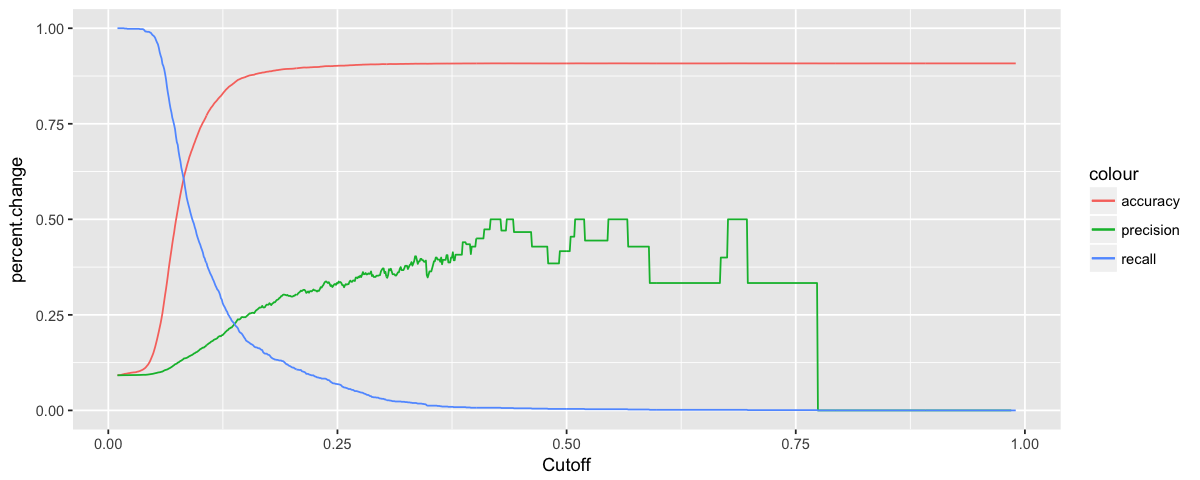

In [66]:
# Range for cuttoff
cutoffRange <- seq(.01,.99,length=1000)
perfMatrix <- performanceMetric(cutoffRange = cutoffRange, 
                                y = yTestLabel$readmitted, 
                                y_hat = unlist(diabetic.ridge.predict))

perfDF <- data.frame(perfMatrix)
names(perfDF) <- c('accuracy', 'precision', 'recall')
head(perfDF)

# Plot Accuracy, precision and recall
options(repr.plot.width=10, repr.plot.height=4)
p <- plotPerfMetric(perfDF, cutoffRange)
p

--> LASSO:

In [ ]:
diabetic.lasso.cv <- cv.glmnet(x=as.matrix(xTrainData), y=as.matrix(yTrainLabel), alpha=1, family='binomial')
lambdaBest_ls <- diabetic.lasso.cv$lambda.min

diabetic.lasso.fit <- glmnet(x=as.matrix(xTrainData), y=as.matrix(yTrainLabel), alpha=1, lambda=diabetic.lasso.cv$lambda.min, family='binomial')
diabetic.lasso.predict <- predict(diabetic.lasso.fit, newx = as.matrix(xTestData), s = lambdaBest, type = "response") 

## Model 2 : Lasso | Ridge | ELNET:
------

#### Prepare Data set to use GLMNET:

In [16]:
# Individual Model Fit
model.lasso <- glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=1, family="binomial")
model.ridge <- glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=0, family="binomial")
model.elnet <- glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=0.5, family="binomial")

In [17]:
# Best Model using Cross Validation
model.lasso.cv = cv.glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=1, family='binomial')
model.ridge.cv = cv.glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=0, family='binomial')
model.elnet.cv = cv.glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=0.5, family='binomial')

# Best model using cross validation, where error measure type is "class"
model.lasso.cv2 = cv.glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=1, family='binomial', type.measure = "class")
model.ridge.cv2 = cv.glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=0, family='binomial', type.measure = "class")
model.elnet.cv2 = cv.glmnet(x=as.matrix(xTrain.dummy.clean), y=yTrain.dummy.clean, alpha=0.5, family='binomial', type.measure = "class")

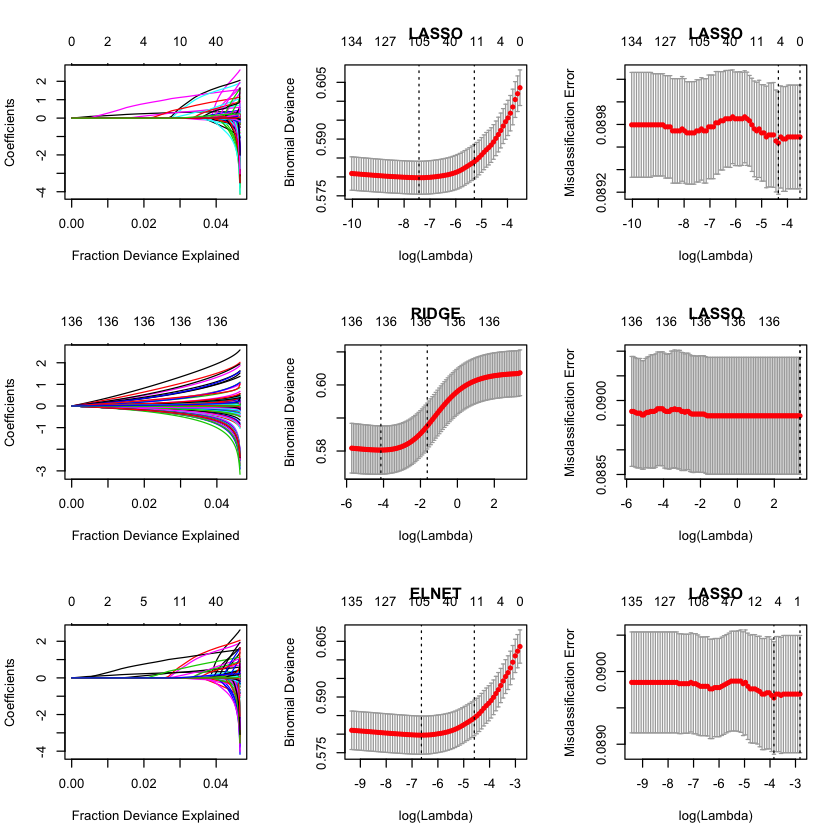

In [37]:
par(mfrow=c(3,3))
# plot(lasso.glm.model)
plot(model.lasso, xvar="dev")   # label = TRUE
plot(model.lasso.cv, main="LASSO")
plot(model.lasso.cv2, main="LASSO")

plot(model.ridge, xvar="dev")   # Plots the 
plot(model.ridge.cv, main="RIDGE")
plot(model.ridge.cv2, main="RIDGE")

plot(model.elnet, xvar="dev")   # Plots the 
plot(model.elnet.cv, main="ELNET")
plot(model.elnet.cv2, main="ELNET")

In [58]:
# Predict
predict.res.model.lasso.cv <- predict(model.lasso.cv, newx = as.matrix(xTest.dummy.clean), s = "lambda.min", type = "class") # Will produce the probability value
predict.cls.model.ridge.cv <- predict(model.ridge.cv, newx = as.matrix(xTest.dummy.clean), s = "lambda.min", type = "class")
predict.cls.model.elnet.cv <- predict(model.elnet.cv, newx = as.matrix(xTest.dummy.clean), s = "lambda.min", type = "class")

predict.res.model.lasso.cv2 <- predict(model.lasso.cv2, newx = as.matrix(xTest.dummy.clean), s = "lambda.min", type = "class") # Will produce the probability value
predict.cls.model.ridge.cv2 <- predict(model.ridge.cv2, newx = as.matrix(xTest.dummy.clean), s = "lambda.min", type = "class")
predict.cls.model.elnet.cv2 <- predict(model.elnet.cv2, newx = as.matrix(xTest.dummy.clean), s = "lambda.min", type = "class")

In [62]:
predic_table <- table(yTest.dummy.clean, predict.cls.model.ridge.cv)
ftable(predic_table)

                  predict.cls.model.elnet.cv     0     1
yTest.dummy.clean                                       
0                                            12726    11
1                                             1250     5

In [25]:
opt <- predict(model.lasso, newx = as.matrix(xTrain.dummy.clean), type = "class", s = c(0.05, 0.01))  # s is the list of lamdas at which we want to make the prediction
# opt


In [29]:
# Lets look at the coefficient value at the best lambda value of (lambda.min)
coef(model.lasso.cv2, s = "lambda.min")

140 x 1 sparse Matrix of class "dgCMatrix"
                                                                1
(Intercept)                                           -2.45179091
time_in_hospital                                       0.00707845
num_lab_procedures                                     .         
num_procedures                                         .         
num_medications                                        .         
number_outpatient                                      .         
number_emergency                                       .         
number_inpatient                                       0.25967579
number_diagnoses                                       .         
raceAsian                                              .         
raceCaucasian                                          .         
raceHispanic                                           .         
racemissing                                            .         
raceOther                        